In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/PJ3_Translator')
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/PJ3_Translator']


In [3]:
import pandas as pd
import csv

In [4]:
spoken_train_path='/content/drive/MyDrive/PJ3_Translator/spoken_train.csv'
spoken_valid_path='/content/drive/MyDrive/PJ3_Translator/spoken_valid.csv'
spoken_test_path='/content/drive/MyDrive/PJ3_Translator/spoken_test.csv'

spoken_train=pd.read_csv(spoken_train_path)
spoken_valid=pd.read_csv(spoken_valid_path)
spoken_test=pd.read_csv(spoken_test_path)

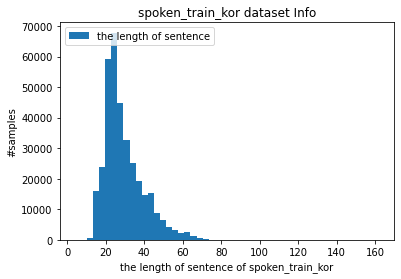

- max = 162 | min = 4 | mean = 29.40 | std = 10.41 | median = 27.0 | "제1사분위수" = 22.0 | "제3사분위수" = 34.0


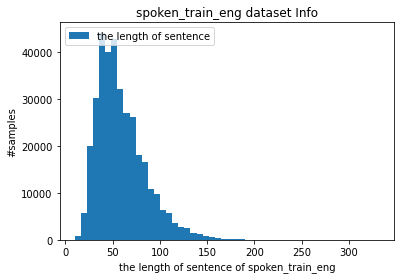

- max = 332 | min = 10 | mean = 59.21 | std = 25.83 | median = 54.0 | "제1사분위수" = 40.0 | "제3사분위수" = 73.0
-------------------------------------------------------------


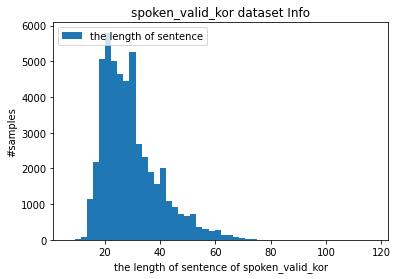

- max = 117 | min = 7 | mean = 29.40 | std = 10.39 | median = 27.0 | "제1사분위수" = 22.0 | "제3사분위수" = 34.0


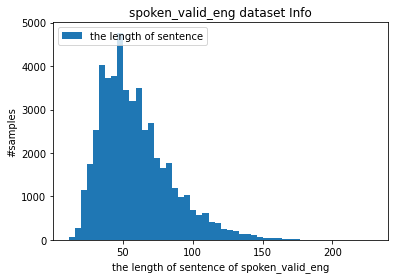

- max = 229 | min = 11 | mean = 59.09 | std = 25.62 | median = 54.0 | "제1사분위수" = 40.0 | "제3사분위수" = 73.0
-------------------------------------------------------------


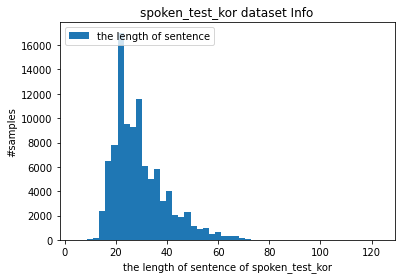

- max = 123 | min = 4 | mean = 29.40 | std = 10.41 | median = 27.0 | "제1사분위수" = 22.0 | "제3사분위수" = 34.0


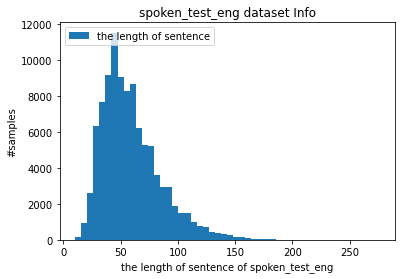

- max = 276 | min = 10 | mean = 59.27 | std = 25.88 | median = 54.0 | "제1사분위수" = 41.0 | "제3사분위수" = 73.0


In [ ]:
#histogram
import matplotlib.pyplot as plt
import numpy as np
def histogram(lens,type_name):
  plt.hist(lens,bins=50,label='the length of sentence')
  plt.xlabel(f'the length of sentence of {type_name}')
  plt.ylabel('#samples')
  plt.legend(loc='upper left')
  plt.title(f'{type_name} dataset Info')
  plt.show()
  print(f'- max = {np.max(lens)} | min = {np.min(lens)} | mean = {np.mean(lens):.2f} | std = {np.std(lens):.2f} | median = {np.median(lens)} | "제1사분위수" = {np.quantile(lens,0.25)} | "제3사분위수" = {np.quantile(lens,0.75)}')

def EDA(dataset,type_name):
  length_kor,length_eng=[],[]
  for i in range(len(dataset)):
    length_kor.append(len(dataset['Kor'][i]))
    length_eng.append(len(dataset['Eng'][i]))

  #histogram & print
  histogram(length_kor,type_name=f'{type_name}_kor')
  histogram(length_eng,type_name=f'{type_name}_eng')

EDA(spoken_train,'spoken_train')
print('-------------------------------------------------------------')
EDA(spoken_valid,'spoken_valid')
print('-------------------------------------------------------------')
EDA(spoken_test,'spoken_test')

In [5]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.4 MB/s eta 0:00:00


In [6]:

#baseline train
import sentencepiece
from typing import Dict, List
import csv

from transformers import (
    EncoderDecoderModel,
    PreTrainedTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Trainer,
    GPT2Tokenizer,
    GPT2Model,
    ElectraTokenizer,
    ElectraModel,
    GPT2Tokenizer as BaseGPT2Tokenizer

)

import torch

from transformers.models.encoder_decoder.modeling_encoder_decoder import EncoderDecoderModel


In [7]:
class PairedDataset:
    def __init__(self, 
        src_tokenizer: PreTrainedTokenizer, tgt_tokenizer: PreTrainedTokenizer,
        file_path: str
    ):
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = tgt_tokenizer
        with open(file_path, 'r') as fd:
            self.data = [row[1:] for row in csv.reader(fd)]

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        src, trg = self.data[index]
        embeddings = self.src_tokenizer(src, return_attention_mask=False, return_token_type_ids=False)
        embeddings['labels'] = self.trg_tokenizer(trg, return_attention_mask=False)['input_ids']

        return embeddings

    def __len__(self):
        return len(self.data)

class GPT2Tokenizer(BaseGPT2Tokenizer):
    def build_inputs_with_special_tokens(self, token_ids: List[int], _) -> List[int]:
        return token_ids + [self.eos_token_id]


In [ ]:

#%%


src_tokenizer = ElectraTokenizer.from_pretrained('monologg/koelectra-base-v3-finetuned-korquad')
trg_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

dataset = PairedDataset(src_tokenizer, trg_tokenizer, '/content/drive/MyDrive/PJ3_Translator/spoken_train.csv')
eval_dataset = PairedDataset(src_tokenizer, trg_tokenizer, '/content/drive/MyDrive/PJ3_Translator/spoken_valid.csv')

# %%

model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    'monologg/koelectra-base-v3-finetuned-korquad',
    'gpt2',
    pad_token_id=trg_tokenizer.bos_token_id
)

#model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/PJ3_Translator/test1_dump/best_model')#이전에 학습시켰던 dump 중 best_model들고오기
model.config.decoder_start_token_id = trg_tokenizer.bos_token_id

# %%
collator = DataCollatorForSeq2Seq(src_tokenizer, model)

arguments = Seq2SeqTrainingArguments(
    output_dir='/content/drive/MyDrive/PJ3_Translator/test7_dump',
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    gradient_accumulation_steps=4,
    save_total_limit=5,
    dataloader_num_workers=2,
    #fp16=True,
    load_best_model_at_end=True,
    #generation_max_length=50
)

trainer = Trainer(
    model,
    arguments,
    data_collator=collator,
    train_dataset=dataset,
    eval_dataset=eval_dataset
)

trainer.train()

model.save_pretrained("/content/drive/MyDrive/PJ3_Translator/test9_dump/best_model")
# %%

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/111 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/591 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/449M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-base-v3-finetuned-korquad were not used when initializing ElectraModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.4.crossattention.masked_bias', 'h.4.crossattention.bias', 'h.4.ln_cross_attn.weight', 'h.8.crossattention.q_attn.weight', 'h.4.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.8.crossattention.bias', 'h.2.crossattention.c_attn.weight', 'h.7.crossattention.c_attn.weight', 'h.3.crossattention.bias', 'h.5.crossattention.q_attn.weight', 'h.5.crossattention.c_proj.bias', 'h.3.crossattention.masked_bias', 'h.8.crossattention.c_proj.weight', 'h.9.crossattention.bias', 'h.0.crossattention.c_attn.weight', 'h.6.crossattention.c_proj.weight', 'h.5.crossattention.c_proj.weight', 'h.1.crossattention.c_attn.weight', 'h.3.crossattention.c_proj.bias', 'h.6.ln_cross_attn.weight', 'h.1.crossattention.masked_bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.6.crossattention.c_proj.bias', 'h.10.ln_cross_

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 350001
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 54690
  Number of trainable parameters = 265137408
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder frame

Epoch,Training Loss,Validation Loss


In [8]:
src_tokenizer = ElectraTokenizer.from_pretrained('monologg/koelectra-base-v3-finetuned-korquad')
trg_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/PJ3_Translator/test7_dump/best_model')#이전에 학습시켰던 dump 중 best_model들고오기
model.eval()
model.cuda()
model.config.decoder_start_token_id = trg_tokenizer.bos_token_id

In [ ]:
spoken_test

In [11]:
#-------------변경해야함--------------------------------
p1=[]
for i in range(int(len(spoken_test)/10)):
  text = spoken_test['Kor'][i]
  embeddings = src_tokenizer(text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
  #print(text, embeddings)
  embeddings = {k: v.cuda() for k, v in embeddings.items()}
  output = model.generate(**embeddings)[0, 1:-1]
  p1.append(trg_tokenizer.decode(output.cpu()))
  print(trg_tokenizer.decode(output.cpu()),len(p1))


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
If you fix it by tomorrow, I will send it to the interviewee. 5001
And I was happy to bring good things to me. 5002
We all went to the valley together today. 5003
How can you not like me? 5004
Please eat as much as you want. 5005
I ate dog meat with my girlfriend at Cheonggyecheon. 5006
It is more profitable to show your warmth to people. 5007
As a result, my work time was reduced. 5008
I helped the professor and taught the students. 5009
In contrast, the maximum amount of consumption, consumption, destruction, and creation of technology are 5010
This is done through efficient utilization of resources. 5011
It is hard to memorize a person's name. 5012
I just wanted to help you. 5013
When the customer cannot find the item, they find it instead. 5014
When can we meet again? 5015
Erythritate will strengthen your skin. 5016
Well, you don't buy things online. 5017
This coupon is valid for three stores here. 5018
We decided to go to the stea

In [12]:
p2=[]
for i in range(int(len(spoken_test)/10),int(2*(len(spoken_test)/10))):
  text = spoken_test['Kor'][i]
  embeddings = src_tokenizer(text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
  #print(text, embeddings)
  embeddings = {k: v.cuda() for k, v in embeddings.items()}
  output = model.generate(**embeddings)[0, 1:-1]
  p2.append(trg_tokenizer.decode(output.cpu()))
  print(trg_tokenizer.decode(output.cpu()),len(p2))

Streaming output truncated to the last 5000 lines.
I always consult my worries on my own. 5001
Usually, people do things that are impossible for human beings. 5002
As you know, thermal imaging cameras are not a product that is sold in a single order 5003
There is only a local train at this station. 5004
Sweet potato contains many minerals, vitamins, and EPA, which helps to increase the level of 5005
Think positively as if the situation is vague. 5006
Currently, most of the domestic universities are experiencing difficulties in operating due to the decrease in students 5007
We are a company specialized in children's products in Korea. 5008
Teach them to speak. 5009
There were several other customers here and everyone was impressed. 5010
The topic of this video is not a daily or a light topic. 5011
I put on the shoes as soon as I bought them. 5012
If possible, please find out the earliest date. 5013
I want to see your eyes only looking at me. 5014
As you know, it is not our duty. 5015
I 

In [18]:
len(p1+p2)

20000

In [23]:
p3=[]
for i in range(int(2*(len(spoken_test)/10)),int(3*(len(spoken_test)/10))):
  text = spoken_test['Kor'][i]
  embeddings = src_tokenizer(text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
  #print(text, embeddings)
  embeddings = {k: v.cuda() for k, v in embeddings.items()}
  output = model.generate(**embeddings)[0, 1:-1]
  p3.append(trg_tokenizer.decode(output.cpu()))
  print(trg_tokenizer.decode(output.cpu()),len(p3))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
It seems that you sent me your picture too long. 5001
Excessive smoking is a risk factor for lung cancer. 5002
Let's start the mukbang of eel stew. 5003
I want to read again if I become better at English. 5004
Welcome to our club. 5005
I'm afraid something will happen to you. 5006
Today is Wednesday, Friday, and Friday off. 5007
He rarely reads the news on the Internet in the evening. 5008
Please send an email to work through English from now on. 5009
I am continuously attending the academy. 5010
It doesn't have to be changed by children becoming adults. 5011
Until when do you need it? 5012
I need a friend who can kick me out of my mind. 5013
This picture is drawn by the exhibition. 5014
It was really nice to meet you yesterday and I hope we can meet again soon! 5015
It was very hot and hard but I got a lot of good memories because I could travel 5016
I am the king of insects, the bee. 5017
We decided to play in two teams. 5018
It took

In [24]:
p4=[]
for i in range(int(3*(len(spoken_test)/10)),int(4*(len(spoken_test)/10))):
  text = spoken_test['Kor'][i]
  embeddings = src_tokenizer(text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
  #print(text, embeddings)
  embeddings = {k: v.cuda() for k, v in embeddings.items()}
  output = model.generate(**embeddings)[0, 1:-1]
  p4.append(trg_tokenizer.decode(output.cpu()))
  print(trg_tokenizer.decode(output.cpu()),len(p4))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Because of that, I couldn't issue a guarantee. 5001
I'm going to the park, so just go. 5002
I'll find out if there is any way I can help. 5003
I am a shy and introvert person. 5004
Also, students lack exercise and sleep. 5005
My house is pleasant and has a nice view. 5006
Please send the defective product to Korea and receive the A/S. 5007
This is a work that shows various emotions that change from boy to man. 5008
It seems like it was after dinner yesterday. 5009
This is a natural ingredient extracted from plants, which helps skin to moisturize and helps to 5010
She said she would buy the meat after work. 5011
The snail is carrying the shell on its back. 5012
At this time, when the LED lamp on the charger indicates red, it means 'charging 5013
If you bend the rope often, the strength will decrease. 5014
I want to get a call from a Korean service center. 5015
How much is the tax audit agency's fee per year? 5016
I am in charge of colle

In [28]:
p5=[]
for i in range(int(4*(len(spoken_test)/10)),int(5*(len(spoken_test)/10))):
  text = spoken_test['Kor'][i]
  embeddings = src_tokenizer(text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
  #print(text, embeddings)
  embeddings = {k: v.cuda() for k, v in embeddings.items()}
  output = model.generate(**embeddings)[0, 1:-1]
  p5.append(trg_tokenizer.decode(output.cpu()))
  print(trg_tokenizer.decode(output.cpu()),len(p5))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
I prefer a clear expression. 5001
I will do three things to improve my English. 5002
This video was suspended due to copyright rights and violation of the terms of use. 5003
I always want to say that my heart is happy. 5004
The trust is sacred to us, says Eiffel. 5005
This knife is known as Macbeth. 5006
The left side is the picture before removing the noise, and the right side is the image 5007
I'm also going there. 5008
The United States invests a lot in the commercial industry. 5009
Even if regret comes to my nose, I should keep doing it. 5010
If you have any questions, please feel free to contact us. 5011
I have briefly introduced your company in the last email, but if you don't mind, 5012
The dumplings that are grilled on a frying pan are very delicious. 5013
It is possible on Saturday evening or Sunday. 5014
How can we work with your company as a reseller or distributor in India market? 5015
But your information is not recorded o

In [ ]:
p6=[]
for i in range(int(5*(len(spoken_test)/10)),int(6*(len(spoken_test)/10))):
  text = spoken_test['Kor'][i]
  embeddings = src_tokenizer(text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
  #print(text, embeddings)
  embeddings = {k: v.cuda() for k, v in embeddings.items()}
  output = model.generate(**embeddings)[0, 1:-1]
  p6.append(trg_tokenizer.decode(output.cpu()))
  print(trg_tokenizer.decode(output.cpu()),len(p6))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
I think the country is the priority for individuals. 2083
Currently, this company has filed for bankruptcy in court and we have completed the bond declaration in 2084
When is the check-in time at the hotel I reserved? 2085
Will the additional scrutiny be determined by the result of the audit? 2086
The dispute was resolved and the refund agreement was also concluded. 2087
Can I get it back today? 2088
I will be with you on the weekend. 2089
We need to implement the plan additionally and design their own special plan. 2090
My dream was to be a kindergarten teacher. 2091
Actually, I don't know how their eyes look because I didn't have a German friend 2092
Is there any country as sensitive as Korea? 2093
Is there anything I should bring to the party? 2094
You will get Samsung smartphone. 2095
The exchange rate fluctuates every day, so I will inform you the exchange rate for the 2096
My younger sister doesn't like reading. 2097
I am getting

In [ ]:

df_sub_with_Eng_60000 = pd.DataFrame({'Korean' : spoken_test['Kor'][:60000], 'English' : spoken_test['Eng'][:60000], 'prediction' : p1+p2+p3+p4+p5+p6})
#변경해야함
df_sub_60000 = pd.DataFrame({'prediction' : p1+p2+p3+p4+p5+p6,'Korean' : spoken_test['Kor'][:60000]})

In [ ]:
df_sub_with_Eng_60000

In [ ]:
df_sub_with_Eng_60000.to_csv('/content/drive/MyDrive/PJ3_Translator/spoken2eng_with_original_Eng_60000.csv')
df_sub_60000.to_csv('/content/drive/MyDrive/PJ3_Translator/spoken2eng_60000.csv')